<a href="https://colab.research.google.com/github/srigouri/CE888-lab/blob/main/2101259.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CASUAL INFERENCE ON IHDP AND JOBS DATASET 
-------------------

My assignment is to train a machine learning model for which casuality remains a hurdle.Making predictions and dealing with unfamiliar events is difficult when there is a lack of casual knowledge.Casuality can help machine learning's inability to generalise.Here the task is divided into 2 parts.
Part-1 deals with IHDP dataset and 
Part-2 deals with Jobs dataset.

# Loading required packages:

In [1]:
!pip install econml

     |████████████████████████████████| 3.3 MB 5.1 MB/s 
     |████████████████████████████████| 123 kB 43.8 MB/s 
     |████████████████████████████████| 77 kB 3.9 MB/s 
     |████████████████████████████████| 356 kB 38.4 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491660 sha256=5cca48db98225c587935f19c652d0ba1601e58c2efb856cb511229034d373a82
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [2]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import dowhy
from dowhy import CausalModel

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**PART-1**

---


**PROBLEM SETTING:**



Part-1: To estimate the casual effects of how the family support (treatment) effects the cognitive test score for the child (outcome).


Loading IHDP Dataset:

In [3]:
ihdp_data=pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/ihdp.csv')
ihdp_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,t,yf,ycf,ite
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.771232,-0.298509,4.657928
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.956273,5.783770,3.428604
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.164164,7.055789,3.658195
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.172307,1.379697,4.585505
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.834469,2.747986,4.265591


In [4]:
X=ihdp_data[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25']]
T=ihdp_data['t']
Y=ihdp_data['yf']
ite=ihdp_data['ite']

Applying Principal Component Analysis(PCA) for dimensionality reduction of X which has got 25 features as inputs

In [5]:
pca = PCA(n_components=1)
pca.fit(X)

PCA(n_components=1)

In [6]:
X_pca=pca.fit_transform(X)

In [7]:
T.value_counts()

0.0    608
1.0    139
Name: t, dtype: int64

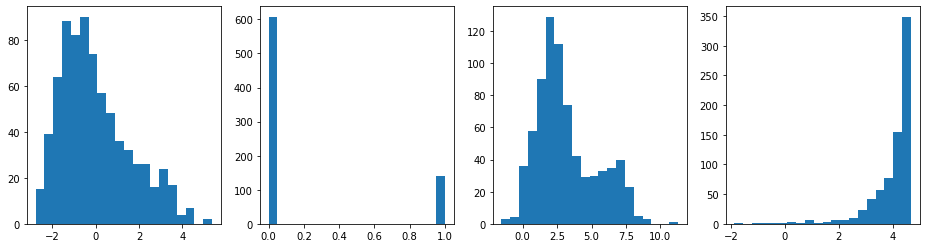

In [8]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].hist(X_pca, bins=bins)
axs[1].hist(T, bins=bins)
axs[2].hist(Y, bins=bins)
axs[3].hist(ite, bins=bins)
plt.show()

**Treatment Effect:**        

The Average Treatment Effect (ATE) builds on ITE:
AT E = E[ITE]
Note: empirical (sample) ATE is the mean of ITEs

In [9]:
ATE=np.mean(ite)
ATE

In [10]:
Y.describe()

count    747.000000
mean       3.159538
std        2.179956
min       -1.543902
25%        1.626779
50%        2.577294
75%        4.494637
max       11.268228
Name: yf, dtype: float64

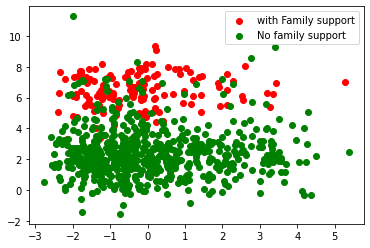

In [11]:
limit = 10000
plt.scatter(X_pca[T == 1][:limit], Y[T == 1][:limit], c = "r", label = "with Family support")
plt.scatter(X_pca[T == 0][:limit], Y[T == 0][:limit], c = "g", label = "No family support")
plt.legend(ncol=1)
plt.savefig('ihdp_scatter.png',dpi=1200)

Hence,it is clear that the cognitive score of y factuals(outcome) is high where treatment is 1.i.e.,with family support the cognitive score is high for pre-mature infants with low birth-weight.

**Data-Preprocessing:**

Splitting the ihdp_data into training and testing for evaluation purposes with 80/20 ratio.Using X_pca as input for training the model.

Data is standardized using StandardScaler

In [12]:
X_pca_train, X_pca_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(X_pca, T, Y, ite, test_size=0.2)

scaler_x = StandardScaler()
X_pca_train = scaler_x.fit_transform(X_pca_train)
X_pca_test = scaler_x.transform(X_pca_test)

**PART-2**



---------------------------------------------------------------------------------------------------------



**PROBLEM SETTING:**

Loading Jobs Dataset:

The Jobs dataset is a combination of the experiment done by as part of the National
Supported Work Program (NSWP) and observational data from the Panel Study of Income Dynamics (PSID)

In [13]:
Jobs_data=pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/jobs.csv')
Jobs_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,t,y,e
0,-0.614282,1.464727,0.0,0.0,1.0,0.0,2.393250,2.746196,-0.653311,-0.656913,1.627531,2.462337,2.937244,0.0,0.0,2.843909,0.0,0.0,1.0,0.0
1,-0.802463,0.101835,0.0,0.0,1.0,0.0,0.109885,0.498271,-0.785284,-0.743407,-0.022502,-0.177193,0.082537,0.0,0.0,0.038422,0.0,0.0,1.0,0.0
2,-0.896553,-0.238888,1.0,0.0,1.0,1.0,-0.085212,-0.148097,-0.847312,-0.781606,-0.361348,-0.286221,-0.303615,0.0,0.0,-0.191304,0.0,0.0,1.0,0.0
3,-0.896553,-0.238888,0.0,0.0,0.0,1.0,0.405581,0.325594,-0.847312,-0.781606,-0.361348,0.023020,-0.039630,0.0,0.0,0.173108,0.0,0.0,1.0,1.0
4,0.138440,-1.601779,1.0,0.0,1.0,1.0,-0.722531,-0.212734,-0.019840,-0.156019,-1.422084,-0.514563,-0.331552,0.0,0.0,-0.779227,0.0,0.0,1.0,0.0
